# 序論：森林火災、フラクタル構造をした油田、拡散

## パーコレーションとは？

In [1]:
using Pkg
using Random
Pkg.add("Distributions")
using Distributions
Pkg.add("Plots")
using Plots
Pkg.add("PyPlot")
pyplot()

   Updating registry at `~/.julia/registries/General`
   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %.0 %57.0 % [===============================>         ]  77.1 %

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


Plots.PyPlotBackend()

In [2]:
"""
    binomialmap(p, dims）
    dimsで示される行列に二項分布（確率p）を生成する
"""
function binomialmap(p::Float64, dims::Tuple{Int,Int})
      return rand(Binomial(1,p),dims[1],dims[2])
end

"""
    binomialmap(p, s）
    s×sで示される正方行列に二項分布（確率p）を生成する
"""
function binomialmap(p::Float64, s::Int)
      return rand(Binomial(1,p),s,s)
end


binomialmap

In [3]:
"""
    blockmap(data; color, yflip, title, titlelocation)
    dataで示されるマップに対応して，colorで示される色で表示する
    yflipがtrueの場合は上下を反転して表示する
"""
function blockmap(data::Array{Int,2}; color::Array{Symbol}, yflip::Bool = true, 
                  title::String = "", titlelocation::String = "center")
    heatmap(data, color = color, yflip = yflip, 
            framestyle = :grid, showaxis = false, bg = :black, colorbar = :none, aspectratio = 1,
            title = title, titlelocation  = titlelocation)
end

blockmap

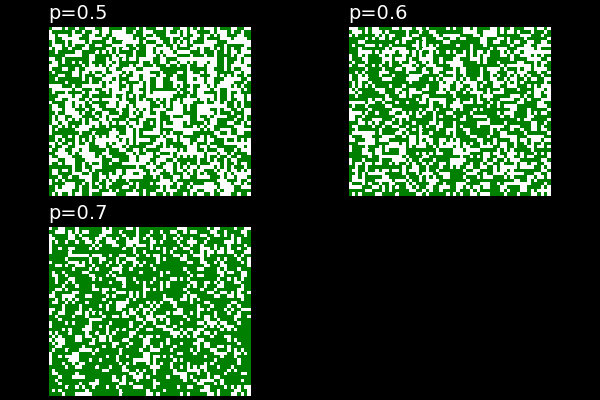

In [4]:
plt=[]
for p = 0.5:0.1:0.7
    data = binomialmap(p,(50,60))
    push!(plt,blockmap(data, color = [:white,:green], title = "p=$(p)", titlelocation = "left"))
end
plot(plt...)

## 森林火災

In [5]:
"""
    isnearest(elem)
    3×３の配列の中心位置が'１'で、最近接位置に'２'があるとき
    trueを返す
"""
function isnearest(elem::Array{Int,2})
    if elem[2,2] == 1 && 
        (any([elem[1,2],elem[3,2],elem[2,1],elem[2,3]] .== 2) ||
         any([elem[1,2],elem[3,2],elem[2,1],elem[2,3]] .== 99))    
        return true
    end
    return false
end

isnearest

In [6]:
"""
    issecondnearest(elem)
    3×３の配列の中心位置が'１'で、最近接位置および第２近接位置に'２'があるとき
    trueを返す
"""
function issecondnearest(elem::Array{Int,2})
    if elem[2,2] == 1 && (any(elem .== 2) || any(elem .== 99))
        return true
    end
    return false
end

issecondnearest

In [7]:
"""
    issecondnearest(elem)
    3×３の配列の中心位置が'１'で、最近接位置および第２近接位置に'２'が２つ以上あるとき
    trueを返す
"""
function isdoublenearest(elem::Array{Int,2})
    if elem[2,2] == 1 && count(x->x==99, elem) + count(x->x==2, elem) >=　2
        return true
    end
    return false
end

isdoublenearest

In [8]:
"""
    fireforest(p, dims, func)
    確率ｐでサイズdimに形成された森林の上端に火をつけ
    funcで示すルールに従って延焼させる。
    火種がなくなるか下端に到達させるまでのループ回数とその時のマップを返す
"""
function fireforest(p::Float64, dims::Tuple{Int,Int}, func::Function)
    data = binomialmap(p,dims)
    replace!(view(data,1,:), 1=>2)
    wdata = zeros(Int, size(data,1)+2, size(data,2)+2) 
    wdata[2:end-1,2:end-1] = data
    counts = 0
    while all(wdata[end-1,:] .!= 2 ) && any(wdata .== 2) 
        replace!(wdata, 2=>99)
        for i= 2:size(wdata,1)-1, j = 2:size(wdata,2)-1
            if func(wdata[i-1:i+1,j-1:j+1])
                wdata[i,j] = 2
            end
        end
        replace!(wdata, 99=>3)
        counts  += 1
    end
    return counts, wdata[2:end-1,2:end-1]
end 

fireforest

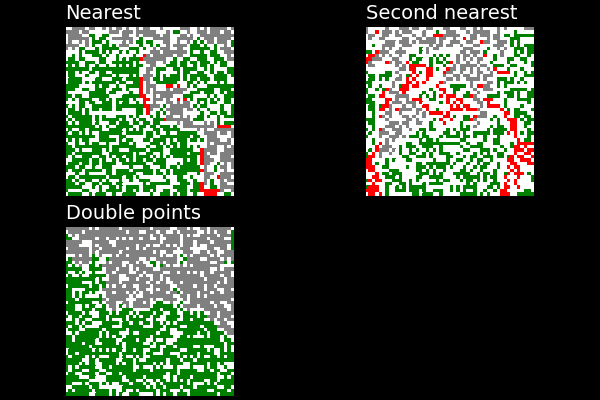

In [9]:
plt=[]
for (p,func,label) in zip([0.6,0.45,0.7],[isnearest,issecondnearest,isdoublenearest],
                            ["Nearest","Second nearest","Double points"])
    counts, data = fireforest(p,(50,50),func)
    push!(plt,blockmap(data,color=[:white, :green, :red, :gray],title = label, titlelocation = "left"))
end
plot(plt...)

In [10]:
"""
    fireforesttime(p, dims, func; nums)
    確率ｐでサイズdimに形成された森林の上端に火をつけ
    funcで示すルールに従って延焼させる。
    火種がなくなるか下端に到達させるまでのループ回数についてnum回繰り返した
    平均を返す
"""
function fireforesttime(p::Float64, dims::Tuple{Int,Int}, func::Function;nums::Int=100)
    sums = 0
    for i = 1:nums
        counts, _ = fireforest(p,dims,func)
        sums += counts
    end
    return sums/nums
end

fireforesttime

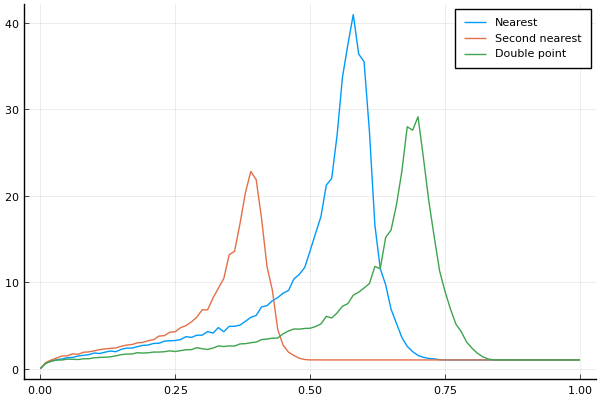

In [11]:
plot()
ps = 0:0.01:1
for (func, label) in zip([isnearest,issecondnearest,isdoublenearest],["Nearest","Second nearest","Double point"])
    times =[]
    for p in ps
        push!(times,fireforesttime(p,(100,100),func))
    end
    plot!(ps,times,label=label)
end
plot!()

## 油田とフラクタル

In [12]:
"""
    findpath(data)
    与えられたdataの中心を'２'として,それにつながる'1'を'２'に変えていき
    中心から繋がっている全ての領域を'２'としたdataを返す
"""
function findpath(data::Array{Int,2})
    if size(data) == (1,1)
        return [2]
    else
        data[2:end-1,2:end-1] = findpath(data[2:end-1,2:end-1])
        wdata = zeros(Int,size(data,1)+2,size(data,2)+2)
        wdata[2:end-1,2:end-1] = data
        checksum = 0
        while checksum != sum(wdata)
            checksum = sum(wdata)
            for i = 2:size(wdata, 1) - 1, j = 2:size(wdata, 2) - 1
                if wdata[i,j] == 1 && any([wdata[i-1,j],wdata[i+1,j],wdata[i,j-1],wdata[i,j+1]] .== 2)
                    wdata[i,j] = 2
                end
            end
        end
        return wdata[2:end-1,2:end-1]
    end
end

findpath

 15.552031 seconds (11.94 M allocations: 942.245 MiB, 56.77% gc time)


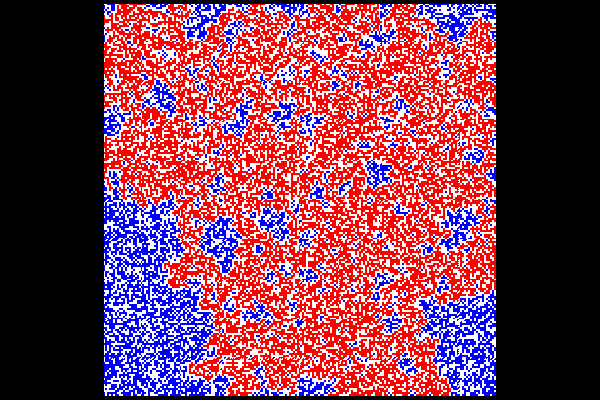

In [13]:
field = binomialmap(0.6,(201,201))
@time field = findpath(field)
blockmap(field,color=[:white, :blue, :red])

In [14]:
"""
    countmap(data)
    サイズLのdataの中心から1,3,5,...(L-1)/2の正方形の区間に含まれる
    連結された領域('2')の数を配列で返す
"""
function countmap(data::Array{Int,2})
    if size(data) == (1,1)
        return [count(x->(x==2),data)]
    else
        res = countmap(data[2:end-1,2:end-1])
        push!(res,count(x->(x==2),data))
        return res
    end
end

countmap

1047.527605 seconds (397.89 M allocations: 31.530 GiB, 30.89% gc time)


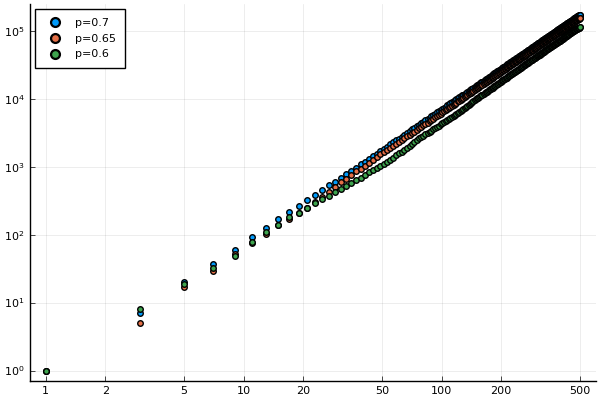

In [16]:
plot(xscale=:log10, yscale=:log10,xtick=((1,2,5,10,20,50,100,200,500),(1,2,5,10,20,50,100,200,500)))
@time for p in [0.70, 0.65,0.60]
    data = binomialmap(p, 501)
    data = findpath(data)
    ms = countmap(data)
    ls = 1:2:size(data,1)
    plot!(ls, ms, seriestype=:scatter, label="p=$(p)")
end
plot!()

In [20]:
"""
    linearleastsquares(x,y)
    y = ax+b で示される１次式に対する最小二乗法を計算して
    係数を返す
"""
function linearleastsquares(x::Array{Float64},y::Array{Float64})
    a = cov(x,y)/std(x)^2
    b = mean(y)-a*mean(x)
    return a,b
end

linearleastsquares

3100.153095 seconds (3.39 G allocations: 308.323 GiB, 33.76% gc time)


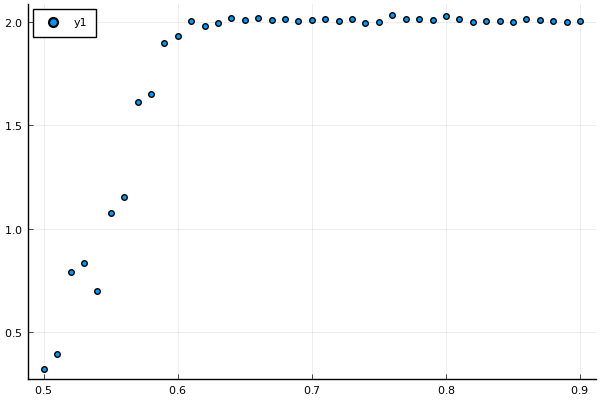

In [18]:
ps = 0.5:0.01:0.9
as = []
@time for p in ps
    amax=0
    for i =1:10
        data = binomialmap(p,301)
        data =findpath(data)
        ms = countmap(data)
        ls = 1:2:size(data,1)
        a,b = linearleastsquares(log.(ls),log.(ms))
        if a > amax
            amax= a
        end
    end
    push!(as,amax)
end
plot(ps,as, seriestype = :scatter)

## 不規則媒質中の拡散

In [21]:
"""
    distance(p1,p2)
    p1とp2の距離を求める
"""
function distance(p1::Tuple{Int,Int},p2::Tuple{Int,Int})
    return sqrt((p2[1]-p1[1])^2+(p2[2]-p1[2])^2)
end

distance

In [22]:
"""
    diffusion(p,tm)
    確率pの二項分布平面の中央から、tmまでの時間中に移動する距離の時間変化を返す
"""
function diffusion(p::Float64,tm::Int)
    ds = []
    data = binomialmap(p,(tm*2+1,tm*2+1))
    s = (tm+1,tm+1)
    pos = s
    for t = 1:tm
        dir = rand(1:4)
        if dir == 1 && pos[1] > 1 && data[pos[1]-1,pos[2]] == 1
            pos = (pos[1]-1, pos[2])
        elseif dir == 2 && pos[2] < size(data,2) && data[pos[1],pos[2]+1] == 1
            pos = (pos[1],pos[2]+1)
        elseif dir == 3 && pos[1] < size(data,1) && data[pos[1]+1,pos[2]] == 1
            pos = (pos[1]+1,pos[2])
        elseif dir == 4 && pos[2] > 1 && data[pos[1],pos[2]-1] == 1
            pos = (pos[1],pos[2]-1)
        end
        push!(ds,distance(pos,s))
    end
    return ds
end

diffusion

557.350476 seconds (3.05 M allocations: 12.038 GiB, 1.33% gc time)


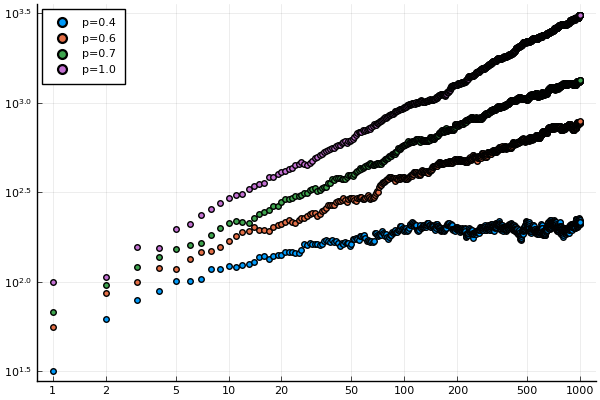

In [23]:
t = 1000
ns = 100
plot(xscale=:log10, yscale=:log10,xtick=((1,2,5,10,20,50,100,200,500,1000),(1,2,5,10,20,50,100,200,500,1000)))
@time for p in [0.4,0.6,0.7,1.0]
    ds = zeros(t)
    for n = 1:ns
        ds .+= diffusion(p,t)
        end
    a,b = linearleastsquares(log.(1:t),log.(ds))
    plot!(1:t, ds, seriestype=:scatter, label="p=$(p)")
end
plot!()